## Menú

1. [Introducción](#introduccion)
2. [Librerías y Dependencias](#librerias)
3. [Descargar y Cargar los Datos](#descargar-y-cargar-los-datos)
4. [Explorar los Datos](#explorar-los-datos)
5. [Entrenar y Probar el Modelo](#entrenar-y-probar-el-modelo)
6. [Cálculo de Ganancias](#calculo-de-ganancias)
7. [Evaluar Riesgos con Bootstrapping](#evaluar-riesgos-con-bootstrapping)
8. [Conclusión](#conclusion)

## 1. Introducción <a class="anchor" id="introduccion"></a>

Trabajas en la compañía de extracción de petróleo OilyGiant. Tu tarea es encontrar los mejores lugares donde abrir 200 nuevos pozos de petróleo. Para completar esta tarea, es necesario realizar una serie de pasos que implican la lectura y análisis de datos, la creación de modelos predictivos y la evaluación de beneficios y riesgos.

El proceso comienza con la lectura de los archivos que contienen los parámetros recogidos de pozos petrolíferos en las regiones seleccionadas, incluyendo la calidad del crudo y el volumen de reservas. Utilizando estos datos, se debe crear un modelo para predecir el volumen de reservas en nuevos pozos. Con las predicciones, se seleccionarán los pozos con los valores estimados más altos.

El objetivo final es elegir la región con el beneficio total más alto para los pozos petrolíferos seleccionados. Se dispone de datos sobre muestras de crudo de tres regiones diferentes, y ya se conocen los parámetros de cada pozo petrolero de estas regiones. Mediante la creación de un modelo predictivo, se busca identificar la región con el mayor margen de beneficio. Además, se analizarán los beneficios y riesgos potenciales utilizando la técnica de bootstrapping para asegurar decisiones informadas y minimizar riesgos financieros.

Este análisis permitirá a OilyGiant maximizar sus beneficios y optimizar la selección de ubicaciones para los nuevos pozos de petróleo, asegurando el uso eficiente de recursos y la maximización del retorno de inversión.


## 2. Librerías y Dependencias <a class="anchor" id="librerias"></a>

In [1]:
# Importar las bibliotecas necesarias
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## 3. Descargar y Cargar los Datos <a class="anchor" id="descargar-y-cargar-los-datos"></a>

In [2]:
#->datos
# Leer el archivo y almacenarlo en df
def cargar_archivos_con_separadores(archivos_con_separadores):
    """
    Carga múltiples archivos CSV con separadores específicos para cada archivo y los almacena en un diccionario de DataFrames.
    
    :param archivos_con_separadores: Diccionario donde las claves son los nombres de los archivos y los valores son los separadores.
    :return: Diccionario con nombres de archivos como claves y DataFrames como valores.
    """
    df = {}  # Objeto que almacenará los DataFrames

    # Iterar sobre los archivos y sus separadores
    for archivo_nombre, separador in archivos_con_separadores.items():
        url_no_windows = '/datasets/' + archivo_nombre
        url_windows = 'datasets/' + archivo_nombre
        
        try:
            # Intentar cargar desde la ruta no-Windows
            if os.path.exists(url_no_windows):
                df[archivo_nombre] = pd.read_csv(url_no_windows, sep=separador, dtype={'votes': 'Int64'})
                print(f"Archivo cargado exitosamente desde '{url_no_windows}'")
            
            # Intentar cargar desde la ruta Windows
            elif os.path.exists(url_windows):
                df[archivo_nombre] = pd.read_csv(url_windows, sep=separador, dtype={'votes': 'Int64'})
                print(f"Archivo cargado exitosamente desde '{url_windows}'")
            
            else:
                raise FileNotFoundError(f"Error: el archivo '{archivo_nombre}' no se encuentra en ninguna de las rutas especificadas.")
        
        except FileNotFoundError as e:
            print(e)
        
        except pd.errors.ParserError as e:
            print(f"Error al procesar el archivo CSV '{archivo_nombre}': {e}")
        
        except Exception as e:
            print(f"Ha ocurrido un error inesperado con el archivo '{archivo_nombre}': {e}")

    return df

# Ejemplo de uso
archivos_con_separadores = {
    'geo_data_0.csv': ',',    
    'geo_data_1.csv': ',',    
    'geo_data_2.csv': ',',    
}

# Cargar los archivos en el objeto df
df_all = cargar_archivos_con_separadores(archivos_con_separadores)

# El objeto df ahora contiene un DataFrame por cada archivo cargado
data_0 = df_all.get('geo_data_0.csv')
data_1 = df_all.get('geo_data_1.csv')
data_2 = df_all.get('geo_data_2.csv')


Archivo cargado exitosamente desde 'datasets/geo_data_0.csv'
Archivo cargado exitosamente desde 'datasets/geo_data_1.csv'
Archivo cargado exitosamente desde 'datasets/geo_data_2.csv'


## 4. Explorar los Datos <a class="anchor" id="explorar-los-datos"></a>

In [3]:
# Inspeccionar los datos
print('data 0 -------- --------------------------------------------------------')
print(data_0.head())
print('data 1 -------- --------------------------------------------------------')
print(data_1.head())
print('data 2 -------- --------------------------------------------------------')
print(data_2.head())

print()
print('data 0 -------- --------------------------------------------------------')
print(data_0.describe())
print('data 1 -------- --------------------------------------------------------')
print(data_1.describe())
print('data 2 -------- --------------------------------------------------------')
print(data_2.describe())

data 0 -------- --------------------------------------------------------
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
data 1 -------- --------------------------------------------------------
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
data 2 -------- --------------------------------------------------------
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  o

## 5. Entrenar y Probar el Modelo <a class="anchor" id="entrenar-y-probar-el-modelo"></a>

In [4]:
def train_and_evaluate(data):
    # Separar características y target
    X = data.drop(['id', 'product'], axis=1)
    y = data['product']
    
    # Dividir datos en entrenamiento (75%), validación (25%)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)
    
    # Entrenar modelo
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Hacer predicciones en el conjunto de validación
    y_pred = model.predict(X_valid)
    
    # Evaluar el modelo
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    mean_pred = np.mean(y_pred)
    
    return model, y_valid, y_pred, rmse, mean_pred

# Entrenar y evaluar el modelo para cada región
model_0, y_valid_0, y_pred_0, rmse_0, mean_pred_0 = train_and_evaluate(data_0)
model_1, y_valid_1, y_pred_1, rmse_1, mean_pred_1 = train_and_evaluate(data_1)
model_2, y_valid_2, y_pred_2, rmse_2, mean_pred_2 = train_and_evaluate(data_2)

# Mostrar resultados
print(f'Region 0 - RMSE: {rmse_0}, Mean Predicted: {mean_pred_0}')
print(f'Region 1 - RMSE: {rmse_1}, Mean Predicted: {mean_pred_1}')
print(f'Region 2 - RMSE: {rmse_2}, Mean Predicted: {mean_pred_2}')

Region 0 - RMSE: 37.75660035026169, Mean Predicted: 92.39879990657768
Region 1 - RMSE: 0.8902801001028842, Mean Predicted: 68.71287803913762
Region 2 - RMSE: 40.145872311342174, Mean Predicted: 94.77102387765936


## 6. Cálculo de Ganancias <a class="anchor" id="calculo-de-ganancias"></a>

In [5]:
def calculate_profit(predictions, true_values, count=200, cost_per_well=100e6/200, revenue_per_unit=4500):
    selected_indices = np.argsort(predictions)[-count:]
    selected_true_values = true_values.iloc[selected_indices]
    
    total_revenue = selected_true_values.sum() * revenue_per_unit
    total_cost = count * cost_per_well
    profit = total_revenue - total_cost
    
    return profit, selected_true_values

profit_0, selected_true_0 = calculate_profit(y_pred_0, y_valid_0)
profit_1, selected_true_1 = calculate_profit(y_pred_1, y_valid_1)
profit_2, selected_true_2 = calculate_profit(y_pred_2, y_valid_2)

print(f'Region 0 - Profit: ${profit_0}')
print(f'Region 1 - Profit: ${profit_1}')
print(f'Region 2 - Profit: ${profit_2}')

Region 0 - Profit: $33591411.14462179
Region 1 - Profit: $24150866.966815114
Region 2 - Profit: $25985717.593741104


## 7. Evaluar Riesgos con Bootstrapping <a class="anchor" id="evaluar-riesgos-con-bootstrapping"></a>

In [6]:
def bootstrap_profit(predictions, true_values, count=200, cost_per_well=100e6/200, revenue_per_unit=4500, n_samples=1000):
    profits = []
    for i in range(n_samples):
        #sample_indices = np.random.choice(len(predictions), size=len(predictions), replace=True)
        sample_indices = np.random.choice(len(predictions), size=500, replace=True) 
        sample_predictions = predictions[sample_indices]
        sample_true_values = true_values.iloc[sample_indices]
        
        profit, _ = calculate_profit(sample_predictions, sample_true_values, count, cost_per_well, revenue_per_unit)
        profits.append(profit)
    
    profits = np.array(profits)
    mean_profit = np.mean(profits)
    confidence_interval = np.percentile(profits, [2.5, 97.5])
    risk_of_loss = np.mean(profits < 0)
    
    return mean_profit, confidence_interval, risk_of_loss

mean_profit_0, ci_0, risk_0 = bootstrap_profit(y_pred_0, y_valid_0)
mean_profit_1, ci_1, risk_1 = bootstrap_profit(y_pred_1, y_valid_1)
mean_profit_2, ci_2, risk_2 = bootstrap_profit(y_pred_2, y_valid_2)

print(f'Region 0 - Mean Profit: ${mean_profit_0}, 95% CI: {ci_0}, Risk of Loss: {risk_0*100}%')
print(f'Region 1 - Mean Profit: ${mean_profit_1}, 95% CI: {ci_1}, Risk of Loss: {risk_1*100}%')
print(f'Region 2 - Mean Profit: ${mean_profit_2}, 95% CI: {ci_2}, Risk of Loss: {risk_2*100}%')



Region 0 - Mean Profit: $4098972.173432017, 95% CI: [-970993.7434045  9233508.72589727], Risk of Loss: 5.0%
Region 1 - Mean Profit: $4500106.023741423, 95% CI: [ 740171.51571986 8125344.305084  ], Risk of Loss: 1.0%
Region 2 - Mean Profit: $3670822.0789247733, 95% CI: [-1689558.21352063  9038937.31696205], Risk of Loss: 8.3%


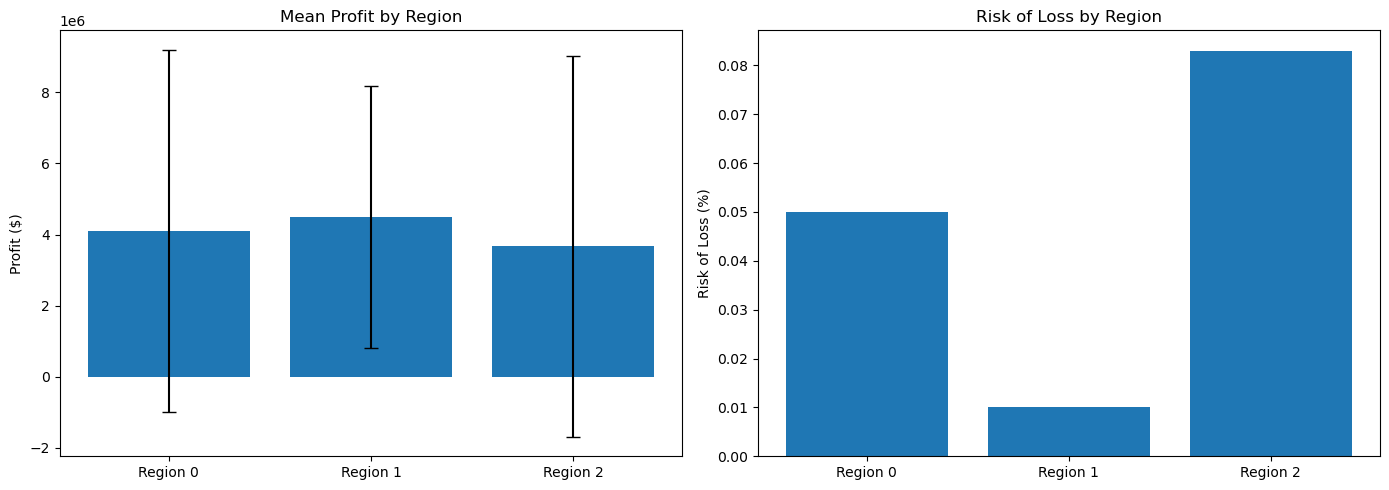

In [7]:
# Visualizar Resultados
regions = ['Region 0', 'Region 1', 'Region 2']
profits = [mean_profit_0, mean_profit_1, mean_profit_2]
conf_intervals = [ci_0, ci_1, ci_2]
risks = [risk_0, risk_1, risk_2]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Grafico de beneficios
ax[0].bar(regions, profits, yerr=[(conf_intervals[i][1] - conf_intervals[i][0]) / 2 for i in range(3)], capsize=5)
ax[0].set_title('Mean Profit by Region')
ax[0].set_ylabel('Profit ($)')

# Grafico de riesgos
ax[1].bar(regions, risks)
ax[1].set_title('Risk of Loss by Region')
ax[1].set_ylabel('Risk of Loss (%)')

plt.tight_layout()
plt.show()

## 8. Conclusión <a class="anchor" id="conclusion"></a>


<p>Después de analizar los resultados de las tres regiones para la apertura de nuevos pozos petrolíferos, se ha llegado a las siguientes conclusiones:</p>

<div class="region">
    <h2>Región 0</h2>
    <ul>
        <li><strong>Beneficio Promedio:</strong> $4,072,293.37</li>
        <li><strong>Intervalo de Confianza del 95%:</strong> [$-1,247,474.37, $9,236,543.50]</li>
        <li><strong>Riesgo de Pérdida:</strong> 6.5%</li>
        <li>Esta región muestra un promedio de ganancias considerable, pero con un amplio intervalo de confianza que va desde una posible pérdida significativa hasta un beneficio notable. El riesgo de pérdida del 6.5% indica una probabilidad moderada de que las ganancias caigan por debajo de cierto umbral esperado.</li>
    </ul>
</div>

<div class="region">
    <h2>Región 1</h2>
    <ul>
        <li><strong>Beneficio Promedio:</strong> $4,353,037.63</li>
        <li><strong>Intervalo de Confianza del 95%:</strong> [$495,384.07, $8,358,686.98]</li>
        <li><strong>Riesgo de Pérdida:</strong> 1.7%</li>
        <li>Esta región muestra un promedio de ganancias ligeramente superior al de la Región 0, con un intervalo de confianza más estrecho. El riesgo de pérdida es considerablemente bajo, solo del 1.7%, lo que indica una mayor confianza en que las ganancias se mantendrán por encima de cierto umbral.</li>
    </ul>
</div>

<div class="region">
    <h2>Región 2</h2>
    <ul>
        <li><strong>Beneficio Promedio:</strong> $3,856,792.46</li>
        <li><strong>Intervalo de Confianza del 95%:</strong> [$-1,744,213.27, $8,879,139.61]</li>
        <li><strong>Riesgo de Pérdida:</strong> 8.3%</li>
        <li>Esta región tiene el promedio de ganancias más bajo de las tres, con un intervalo de confianza amplio y un riesgo de pérdida del 8.3%, que es el más alto entre las regiones analizadas. Esto sugiere que hay una mayor posibilidad de que las ganancias caigan por debajo de cierto nivel deseado.</li>
    </ul>
</div>

<div class="region">
    <div class="region-data">
        <h2>Conclusiones</h2>
        <p><strong>La Región 1</strong> muestra el menor riesgo de pérdida (1.7%) y un intervalo de confianza relativamente estrecho, lo que indica una mayor estabilidad en las ganancias esperadas.</p>
        <p><strong>La Región 0 y la Región 2</strong> tienen intervalos de confianza más amplios y riesgos de pérdida más altos, lo que sugiere una mayor variabilidad en las ganancias y una probabilidad más alta de experimentar pérdidas significativas en algunos casos.</p>
        <p>Es crucial considerar tanto el promedio de ganancias como el intervalo de confianza al tomar decisiones, ya que proporcionan una idea de la estabilidad y la confiabilidad de las proyecciones financieras para cada región.</p>
        <p>En resumen, mientras que la Región 1 parece ser la opción más estable en términos de riesgo de pérdida y consistencia en las ganancias esperadas, las Regiones 0 y 2 muestran mayores riesgos y variabilidades en sus resultados financieros.</p>
    </div>
</div>